In [191]:
!pip -q install -U scikit-learn

import os, random, numpy as np, torch
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)
torch.backends.cudnn.benchmark = False

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE



'cpu'

In [192]:
from google.colab import drive

drive.mount('/content/drive')
RAW_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [193]:
processedList = []

with open(RAW_PATH) as file:
    lines = file.readlines()

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except Exception as e:
        print('Error at line number:', i, '|', e)

Error at line number: 281873 | list index out of range
Error at line number: 281874 | list index out of range
Error at line number: 281875 | list index out of range


In [194]:
import pandas as pd

columns = ['user','activity','time','x','y','z']

df = pd.DataFrame(data = processedList, columns = columns)
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [195]:
df['activity'].value_counts()

,count
activity,
Walking,137375
Jogging,129392
Upstairs,35137
Downstairs,33358
Sitting,4599
Standing,3555


In [196]:
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float') #연속형 수치 -> 실수형으로

In [197]:
activities = df['activity'].value_counts().index

In [198]:
label = LabelEncoder()
df['activity'] = label.fit_transform(df['activity'])
df.head()

,user,activity,time,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164


In [199]:
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object', name='activity')

In [200]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

LABEL = "ActivityEncoded"
le = preprocessing.LabelEncoder()
df[LABEL] = le.fit_transform(df["activity"].values.ravel())
df

X = df[['x', 'y', 'z']]
y = df['ActivityEncoded']


scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,-0.258214,0.697059,0.044419,1
1,0.607502,0.483225,0.145310,1
2,0.590972,0.425654,-0.087046,1
3,-0.245817,1.575011,0.610023,1
4,-0.332596,0.610703,1.548620,1
...,...,...,...,...
343411,-0.105815,0.402609,-0.059530,5
343412,0.265839,0.435820,0.120852,5
343413,-0.031484,0.315054,0.230915,5
343414,-0.391003,0.094656,0.249259,5


In [201]:
#슬라이딩 윈도우####
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler

Fs=20
WINDOW_SIZE = Fs*4
STEP_SIZE   = Fs*2

def get_frames(df, WINDOW_SIZE, STEP_SIZE):

    N_FEATURES = 3

    frames = []
    labels = []

    for i in range(0, len(df) - WINDOW_SIZE, STEP_SIZE):
        x = df['x'].values[i: i + WINDOW_SIZE]
        y = df['y'].values[i: i + WINDOW_SIZE]
        z = df['z'].values[i: i + WINDOW_SIZE]
        #슬라이딩 자르기

        label = stats.mode(df['label'][i: i + WINDOW_SIZE], keepdims=False).mode.item()
        frames.append([x, y, z])
        labels.append(label)
        #가장 많은 값으로 레이블 매기기

    frames = np.asarray(frames).reshape(-1, WINDOW_SIZE, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [202]:
X, y = get_frames(scaled_X, WINDOW_SIZE, STEP_SIZE)

X.shape, y.shape

((8584, 80, 3), (8584,))

In [203]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [204]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (8584, 80, 3)
y shape: (8584,)


In [205]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

X_train.shape, X_test.shape

((6867, 80, 3), (1717, 80, 3))

In [206]:
X_train = X_train.reshape(X_train.shape[0], 80, 3, 1)
X_test  = X_test.reshape(X_test.shape[0], 80, 3, 1)

In [207]:
X_train_t = torch.from_numpy(X_train).float()   # (N,80,3)
X_test_t  = torch.from_numpy(X_test).float()
y_train_t = torch.from_numpy(y_train).long()
y_test_t  = torch.from_numpy(y_test).long()

# Conv2d 입력에 맞게 차원 추가: (N,1<-센서데이터 ,80, 3)
X_train_t = X_train_t.unsqueeze(1)   # channel=1
X_test_t  = X_test_t.unsqueeze(1)

print("X_train_t shape:", X_train_t.shape)  #(N,1,80,3)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=64, shuffle=False)

X_train_t shape: torch.Size([6867, 1, 80, 3, 1])


In [208]:
import torch
import torch.nn as nn

#CNN
cnn = nn.Sequential()
cnn.add_module("conv", nn.Conv2d(1, 32, kernel_size=(2,2))) #입력채널 1(센서데이터), 필터 32개 생성, 필터 크기 2 by 2
cnn.add_module("relu1", nn.ReLU()) #음수 ->0 양수->그대로 -> 왜함? : 비선형성 주려고.
cnn.add_module("drop1", nn.Dropout(0.3)) #과적합 방지라는데 잘 모르겠음 왜 30% 끄는지

#LSTM
# CNN 출력 크기에 따라 input_size 조정 필요

lstm = nn.LSTM(
    input_size=64,   # 예시: W=2라면 32*2=64차원 입력
    hidden_size=64,
    batch_first=True,
    bidirectional=True
)

#FC
fc = nn.Sequential()
fc.add_module("dense1", nn.Linear(64*2, 64))   # bi-LSTM → hidden*2
fc.add_module("relu2", nn.ReLU())
fc.add_module("drop2", nn.Dropout(0.5))
fc.add_module("dense2", nn.Linear(64, 6))      #클래스 6개

#fit ready
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn, lstm, fc = cnn.to(device), lstm.to(device), fc.to(device)

criterion = nn.CrossEntropyLoss()
params = list(cnn.parameters()) + list(lstm.parameters()) + list(fc.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [209]:
from sklearn.metrics import accuracy_score

EPOCHS = 10

for epoch in range(1, EPOCHS+1): #epoch start

    cnn.train();
    lstm.train();
    fc.train();

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        if xb.ndim == 5:   # (B,1,80,3,1) -> (B,1,80,3) 이거 왜함? -> B는 배치 크기, 1 : 채널 수, 80: 시퀀스 길이, 3, xyz 센서 축 3개 conv2d 는 입력 4차원으로 받으니 squeeze(-1)로 마지막 하나 없애버림
          xb = xb.squeeze(-1)

        optimizer.zero_grad()

        # Forward
        feat = cnn(xb)
        B, C, H, W = feat.shape # batch cahnnel hegith width로 쪼개서 변수에 한개씩 넣음
        feat = feat.permute(0,2,1,3).reshape(B, H, C*W) # H를 2번째로 옮김 왜? -> LSTM 이 원하는 모양으로 바꾸려고
        out, _ = lstm(feat)
        logits = fc(out[:,-1,:])

        # Loss + Update
        loss = criterion(logits, yb) # 예측값, 정답라벨 비교 해서 loss로 수치 뽑음.
        optimizer.zero_grad()
        loss.backward() # 역전파 loss 기준으로 가중치를 어떻게 바꿔야지 이 loss가 줄어들까를 계산함.
        optimizer.step() # 위 역전파에서 계산한 기울기값 토대로 모델 파라미터 수정.

    cnn.eval();
    lstm.eval();
    fc.eval()
#--------------------------평가-------------------------
    preds, gts = [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            if xb.ndim == 5:
                xb = xb.squeeze(-1)

            feat = cnn(xb)
            B,C,H,W = feat.shape
            feat = feat.permute(0,2,1,3).reshape(B, H, C*W)
            out, _ = lstm(feat)
            logits = fc(out[:,-1,:])

            preds.extend(logits.argmax(1).cpu().tolist())
            gts.extend(yb.cpu().tolist())

    acc = accuracy_score(gts, preds)
    print(f"[{epoch}/{EPOCHS}] test_acc={acc:.4f}")


[1/10] test_acc=0.6057
[2/10] test_acc=0.7711
[3/10] test_acc=0.8061
[4/10] test_acc=0.8218
[5/10] test_acc=0.8026
[6/10] test_acc=0.8119
[7/10] test_acc=0.8334
[8/10] test_acc=0.8416
[9/10] test_acc=0.8486
[10/10] test_acc=0.8666


Test Accuracy: 0.8666


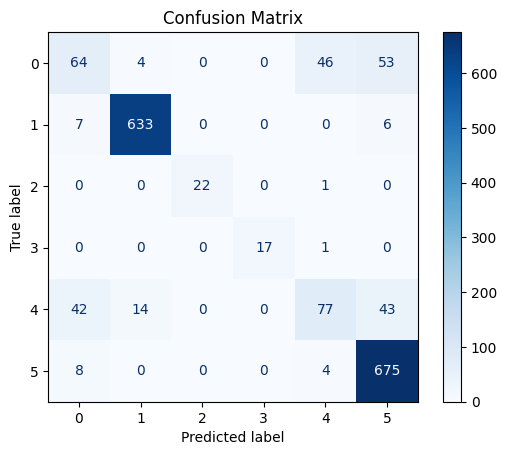

In [210]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

cnn.eval();
lstm.eval();
fc.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)

        # (B,1,80,3,1) -> (B,1,80,3)
        if xb.ndim == 5 and xb.shape[-1] == 1:
            xb = xb.squeeze(-1)

        feat = cnn(xb)                          # (B,32,H,W)
        B, C, H, W = feat.shape
        feat = feat.permute(0, 2, 1, 3).reshape(B, H, C*W)  # (B,H,C*W)
        out, _ = lstm(feat)                     # (B,H,hidden*2)
        feat = out[:, -1, :]                    # (B,hidden*2)
        logits = fc(feat)                       # (B,num_classes)

        preds = logits.argmax(1).cpu().numpy()
        labels = yb.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)


cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.arange(6))  # 클래스 0~5
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()
